In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [13]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
import time

In [43]:
from sklearn.model_selection import train_test_split
import numpy as np

# Cargar los datos desde el archivo de texto
vda   = np.loadtxt("samplesVDA1.txt")



cant_datos = vda.shape[0]
medidas_x_segundo = 400 
npyarray=np.array
tiempo = np.arange(0,cant_datos/400,1/medidas_x_segundo)
tiempo = tiempo*1000


data_y = vda.reshape(-1,1) 
data_x = tiempo.reshape(-1,1)



# Divide los datos en conjuntos de entrenamiento y prueba
vda_entrenamiento, vda_prueba, tiempo_entrenamiento, tiempo_prueba = train_test_split(data_y, data_x, test_size=0.2, random_state=42) #random_state modifica la distancia entre los puntos que tomo para test.
#vda_entrenamiento, vda_prueba, tiempo_entrenamiento, tiempo_prueba = train_test_split(data_y, data_x, test_size=0.2)


data = np.hstack((tiempo_entrenamiento,vda_entrenamiento)) # datos de entrenamiento
dataTest = np.hstack((tiempo_prueba,vda_prueba)) # datos testing




(151,)
(151,)
(302,)


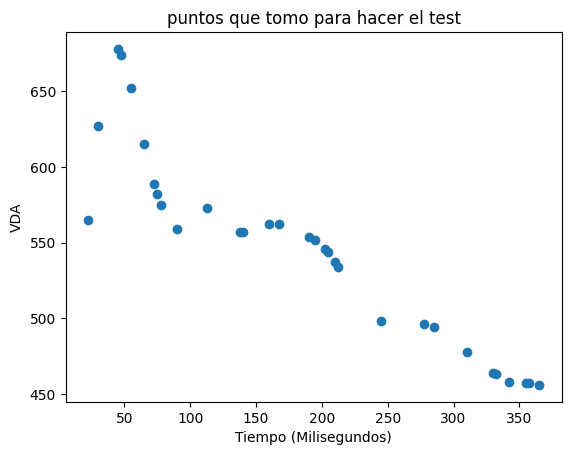

In [15]:
# Crear el gráfico de dispersión (scatter plot)
plt.scatter(tiempo_prueba, vda_prueba)

# Etiquetas de los ejes
plt.xlabel('Tiempo (Milisegundos)')
plt.ylabel('VDA')

# Título del gráfico
plt.title('puntos que tomo para hacer el test')

# Mostrar el gráfico
plt.show()

In [16]:
#CLUSTERING K-MEANS

import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def clusteringk(data,nclusters):

        # Crear un objeto KMeans
        kmeans = KMeans(n_clusters=nclusters)

        # Ajustar el modelo a tus datos
        kmeans.fit(data)

        # Obtener los centroides de los clusters
        centroides = kmeans.cluster_centers_

        # Obtener las etiquetas de cluster para cada punto de datos
        etiquetas = kmeans.labels_

        # Visualizar los resultados
        plt.scatter(data[:, 0], data[:, 1], c=etiquetas)
        plt.scatter(centroides[:, 0], centroides[:, 1], marker='x', s=200, linewidths=3, color='r')
        plt.title(f'Clustering con K-Means (k={nclusters})')
        plt.show()
        
        return etiquetas,centroides


In [17]:
"""
Implementación similar a genfis2 de Matlab.
Sugeno type FIS. Generado a partir de clustering substractivo.
"""


def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))

######################################################################

class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma

#################################################################################################################

# ESTA EDITADO EL DEF VIEW PARA AGRANDAR EL ESPACIO EN X EN EL GRAFICO

class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids


    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        #x = np.linspace(self.minValue -400,self.maxValue + 400,30)

        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)

##################################################################################################################

class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []


###################################################################################################################
    def genfis(self, data, clusters):

        start_time = time.time()
        #El método comienza midiendo el tiempo de ejecución.

        labels, cluster_center = clusteringk(data,clusters) # ACA LE CAMBIE EL METODO DE CLUSTERS (numero de clusters como entrada)

        print("--- %s seconds ---" % (time.time() - start_time))
        n_clusters = len(cluster_center)
        cluster_center = cluster_center[:,:-1]
         #  Se calcula el número de clusters obtenidos (n_clusters) a partir de los centroides y se recorta la última columna de cluster_center,
         #  que generalmente contiene información adicional que no se utiliza en el modelo Sugeno.


        P = data[:,:-1]
        # Se obtienen las variables de entrada P a partir de los datos de entrada data. Luego,
        #  se calculan los valores máximos (maxValue) y mínimos (minValue) de cada variable de entrada.

        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)

        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        #  Se crea una lista de objetos fisInput para cada variable de entrada. Cada objeto fisInput se inicializa con su valor máximo, mínimo y
        #  los centroides de los clusters correspondientes a esa variable.
        self.rules = cluster_center
        self.entrenar(data)

######################################################################################################################
    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
# P contiene las variables de entrada del conjunto de datos data.
# T contiene las salidas deseadas (target) del conjunto de datos data.
        
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs]) 
        #Aquí se calcula la desviación estándar sigma para las funciones de membresía gaussianas utilizadas en el sistema Sugeno.
        #  self.inputs contiene información sobre las variables de entrada.
        
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]
        #  Se calcula la activación de cada regla para cada instancia del conjunto de datos P.
        #  Esto se hace multiplicando las funciones de membresía gaussianas por cada regla y luego tomando el producto.
        #  El resultado es una lista de valores de activación para cada regla y cada instancia de entrada.

        nivel_acti = np.array(f).T
        #  nivel_acti es una matriz donde cada fila corresponde a una instancia del conjunto de datos y cada columna corresponde a una regla.
        #  Contiene los valores de activación de cada regla para cada instancia.


        print("nivel acti")
        print(nivel_acti)
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        # sumMu es un vector que contiene la suma de los valores de activación para cada instancia. 
        # Esto se usa en el cálculo de los coeficientes del sistema Sugeno.
        print("sumMu")
        print(sumMu)
        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]

        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        # Aquí se preparan los datos para el cálculo de los coeficientes. Se añade una columna de unos a la matriz P, 
        # luego se calculan las matrices acti e inp que se utilizan para construir la matriz de coeficientes A.
        


        A = acti*inp/sumMu
        #A es la matriz de coeficientes que se utiliza en el sistema de ecuaciones lineales.

        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu

        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        #Se resuelve el sistema de ecuaciones lineales utilizando mínimos cuadrados y se almacenan las soluciones en self.solutions.
        print(solutions)
        return 0


###############################################################################################################
    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))

        P = np.c_[data, np.ones(len(data))]

        n_vars = P.shape[1]
        n_clusters = len(self.rules)

        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions

        return np.sum(acti*inp*coef/sumMu,axis=1)

#  En resumen, este tramo toma un conjunto de datos de entrada y utiliza el sistema Sugeno previamente entrenado para calcular las salidas correspondientes.
#  este método asume que las variables de entrada y las reglas ya están configuradas en la instancia de la clase fis y
#  que los coeficientes del sistema Sugeno se han calculado previamente durante el entrenamiento


#################################################################################################################

    def viewInputs(self):
        for input in self.inputs:
            input.view()






c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


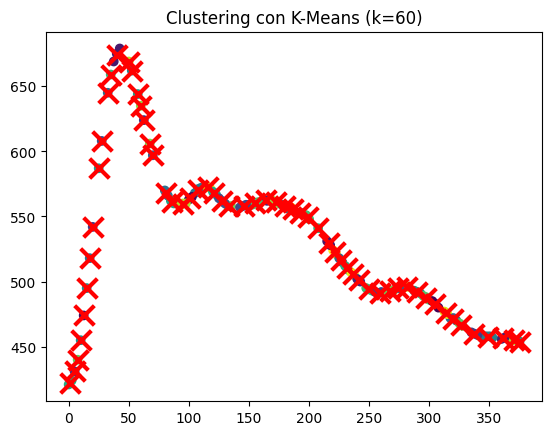

--- 0.9656684398651123 seconds ---
nivel acti
[[0.13063112 0.89083148 0.98237931 ... 0.3251073  0.53292329 0.38273976]
 [0.99840128 0.28100642 0.07730474 ... 0.84757345 0.63547802 0.78911403]
 [0.11187199 0.85666262 0.99362044 ... 0.28952573 0.48829066 0.34377161]
 ...
 [0.12573233 0.88263419 0.98570318 ... 0.31599008 0.52167468 0.37280078]
 [0.85214379 0.62405853 0.26038343 ... 0.99888951 0.94701112 0.99782459]
 [0.9313584  0.51048195 0.1877374  ... 0.99004983 0.87420144 0.96811926]]
sumMu
[[36.9124133 ]
 [30.69040525]
 [35.66419859]
 [30.02652654]
 [43.40464799]
 [43.35874085]
 [40.08114857]
 [36.72827944]
 [33.28596971]
 [41.11830921]
 [42.65293193]
 [24.16331151]
 [22.41362153]
 [37.2105048 ]
 [35.33884006]
 [35.62659572]
 [30.35947815]
 [42.59888755]
 [34.4660568 ]
 [43.4104309 ]
 [25.91298243]
 [35.90775329]
 [34.76139882]
 [31.83297296]
 [43.56667256]
 [43.16371372]
 [40.30255672]
 [42.40467165]
 [42.87163161]
 [43.23532822]
 [27.64827953]
 [39.62659079]
 [39.37603211]
 [39.6178

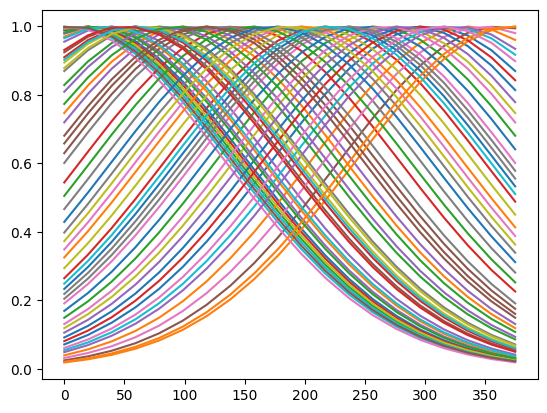

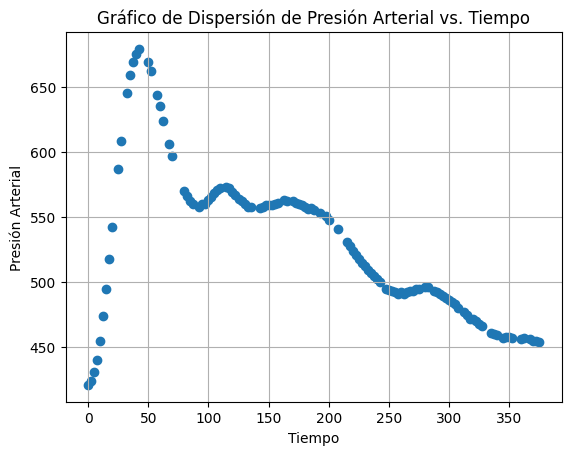

In [18]:
#test genfis 1D


""""
def my_exponential(A, B, C, x):
    return A*np.exp(-B*x)+C

data_x = np.arange(-10,10,0.1)
data_y = -0.5*data_x**3-0.6*data_x**2+10*data_x+1 #my_exponential(9, 0.5,1, data_x)

plt.plot(data_x, data_y)
 plt.ylim(-20,20)
plt.xlim(-7,7)

data = np.vstack((data_x, data_y)).T

"""



fis2 = fis()
#genera el sugeno, clase con reglas (vacia),funcion de pertenencia(vacia) y inputs(vacia).



#numero de clusters (por kmeans)

clusters = 60

fis2.genfis(data,clusters)
# En esta le pone todo con la data , hace el clustering de nuevo dentro de la funcion!(el anterior lo dejamos para ver como quedo el clustering pero aca lo hace de vuelta)
#(0.5 es el ra).



fis2.viewInputs()
# plot de funciones gausiannas (serian las de pertenencias , centro marcado por el centro de clusters)
# las funciones gausiannas tienen maximo en el eje y en 1 [0;1], te dan el grado de pertenencia.
# el espacio x esta recortado solamente al espacio de nuestros datos, por eso no las vemos enteras. LO EDITE AHORA SI SE VEN ENTERAS.




# Al evalfis le metemos datos (tipo numpy) de entrada y nos devuelve la salida calculada (el modelo aca YA esta entrenado y lo estariamos probando).



plt.figure()
plt.scatter(tiempo_entrenamiento,vda_entrenamiento)
plt.xlabel('Tiempo')
plt.ylabel('Presión Arterial')
plt.title('Gráfico de Dispersión de Presión Arterial vs. Tiempo')
plt.grid(True)
plt.show()
#grafico los datos que nos dieron.



In [19]:
# TESTEO 

# Crear una lista para almacenar los errores
errores = []

#fis2.solutions
x = fis2.evalfis((tiempo_prueba)) # testeo con los vda para testeo

#print(f"{tiempo_prueba}")

#print(f"las salidas a los valores introducidos son : {x}")


# muestro las salidas restadas por el valor que se supone que tenian que tener , guardados en la primer celda mas arriba.

for i in range(len(x)):
    resultado = x[i] - vda_prueba[i]
    print(f" error en iteracion {i}, error:  {resultado} , x = {x[i]} , vdaprueba =  {vda_prueba[i]}")
    errores.append(resultado)




# Elevar al cuadrado los valores del array
errores = np.square(errores)

# Calcular la raíz cuadrada de los valores al cuadrado
errores = np.sqrt(errores)

# Calcular el promedio de los errores
promedio_error = np.mean(errores)
print(f"Promedio de errores: {promedio_error}")



 error en iteracion 0, error:  [-0.52868652] , x = 553.4713134765625 , vdaprueba =  [554.]
 error en iteracion 1, error:  [-7.46148682] , x = 670.5385131835938 , vdaprueba =  [678.]
 error en iteracion 2, error:  [0.43774414] , x = 544.437744140625 , vdaprueba =  [544.]
 error en iteracion 3, error:  [0.52990723] , x = 546.5299072265625 , vdaprueba =  [546.]
 error en iteracion 4, error:  [2.45800781] , x = 459.4580078125 , vdaprueba =  [457.]
 error en iteracion 5, error:  [6.66052246] , x = 581.6605224609375 , vdaprueba =  [575.]
 error en iteracion 6, error:  [-0.64526367] , x = 551.354736328125 , vdaprueba =  [552.]
 error en iteracion 7, error:  [-2.733078] , x = 559.2669219970703 , vdaprueba =  [562.]
 error en iteracion 8, error:  [8.60983276] , x = 565.6098327636719 , vdaprueba =  [557.]
 error en iteracion 9, error:  [2.74401855] , x = 536.7440185546875 , vdaprueba =  [534.]
 error en iteracion 10, error:  [-9.94335938] , x = 563.056640625 , vdaprueba =  [573.]
 error en itera

In [ ]:
# GRAFICAR EL ERROR vs R
import numpy as np
import matplotlib.pyplot as plt

# Listas para almacenar los valores de error y clusters
mse = []
cluster_values = []

for iteracion in range(2, 51):
    errores = []
    fis2 = fis()
    #la iteracion son la cantidad de clusters
    fis2.genfis(data, iteracion)

    x = fis2.evalfis(tiempo_prueba)  # testeo con los vda para testeo

    for i in range(len(x)):
        resultado = x[i] - vda_prueba[i]
        errores.append(resultado)

    # Elevar al cuadrado los valores del array
    errores = np.square(errores)

    # Calcular la raíz cuadrada de los valores al cuadrado
    errores = np.sqrt(errores)

    # Calcular el promedio de los errores
    promedio_error = np.mean(errores)
    error_promedio_porcentual = promedio_error/np.max(data_y) 

    mse.append(error_promedio_porcentual*100)
    cluster_values.append(iteracion)

In [27]:

print(f"{mse}")


[20.837240047904714, 3.014705267192447, 3.2963060249160105, 1.3581363545941583, 3.085123184619434, 0.804808659816084, 1.4183694127565376, 0.8419177227390878, 1.3556977823743714, 0.63000411503847, 0.8587641989886322, 0.6365696188225519, 0.849246213065626, 0.5429804913189454, 0.8534935773582808, 0.5617078726459507, 0.8294414153512036, 0.5634850182436696, 0.6702953554104784, 0.5573706243545931, 0.6405814530331367, 0.5642330230833409, 0.6178274738674769, 0.5626055039254156, 0.6633962774861198, 0.5611031227209967, 0.6685011120350878, 0.5649780641375693, 0.6503907977991188, 0.566145142694885, 0.6085552168637762, 0.5637282242427076, 0.6359540369391549, 0.5645455652537408, 0.5492172375320681, 0.5673817476460149, 0.5626592322533781, 0.5676112995000469, 0.5692496085213371, 0.5653698042047182, 0.5613552785001267, 0.5670506915133864, 0.5621514516780879, 0.560941331829552, 0.5521877083209378, 0.5651411268238188, 0.5763171919678117, 0.5654064984841919, 0.5461525184251155]


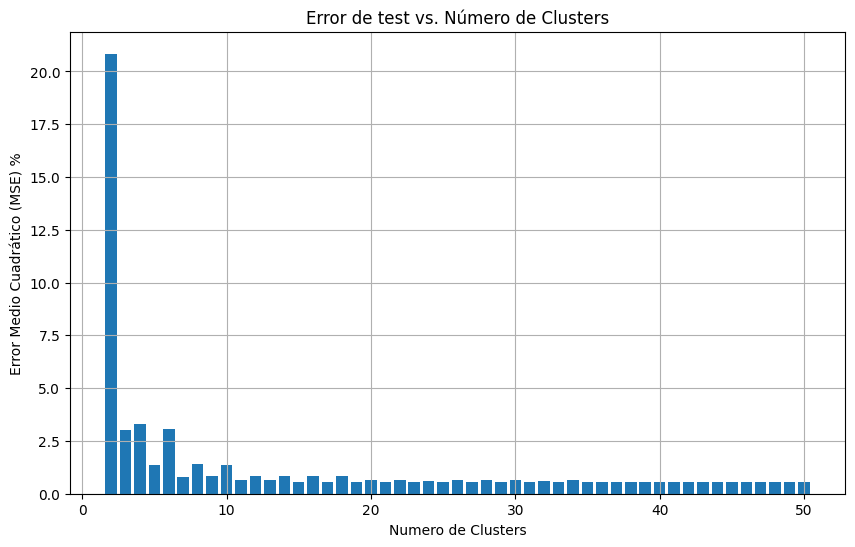

In [33]:
# Ahora, graficar el error vs. el número de clusters
plt.figure(figsize=(10, 6))
plt.bar(cluster_values, mse)
plt.title('Error de test vs. Número de Clusters')
plt.xlabel('Numero de Clusters')
plt.ylabel('Error Medio Cuadrático (MSE) %')
plt.grid(True)
plt.show()

(302,)


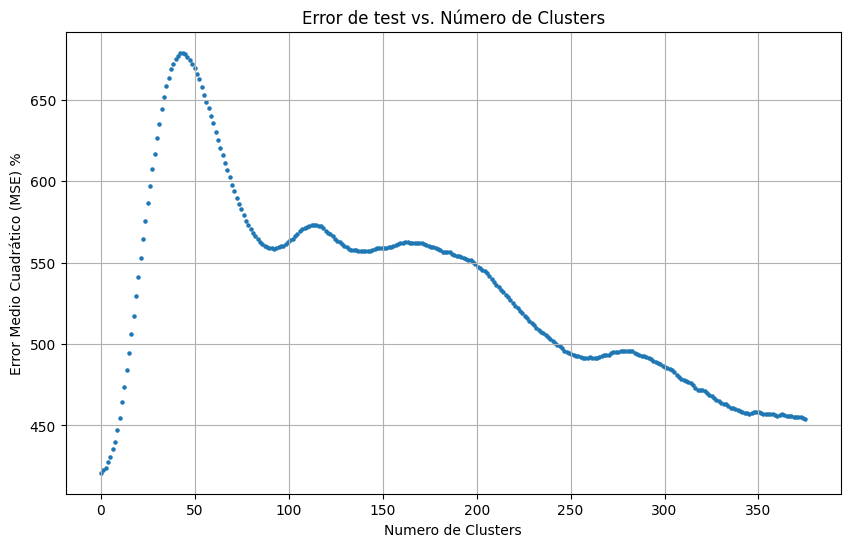

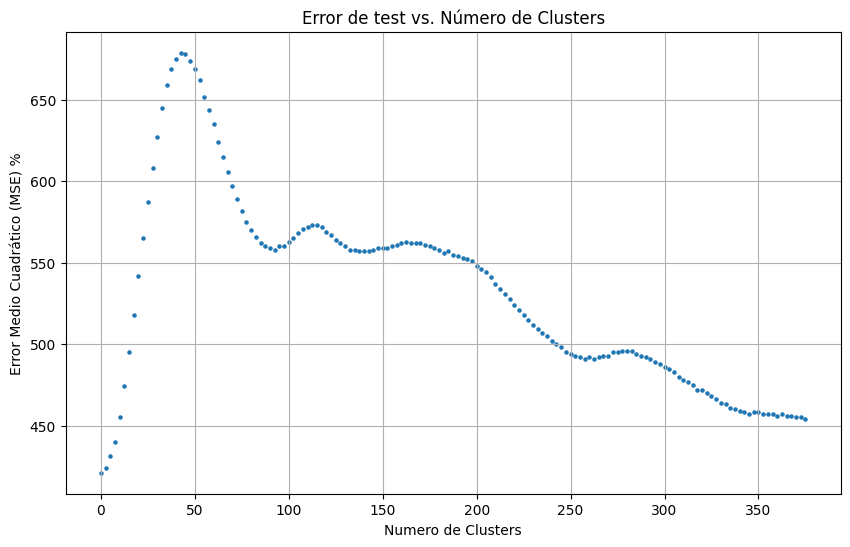

In [46]:
from scipy.interpolate import interp1d

f = interp1d(tiempo, vda, kind='linear')
x_new = np.linspace(0, np.max(tiempo), num=tiempo.shape[0]*2)
y_new = f(x_new)
print(y_new.shape)
#####################################################

plt.figure(figsize=(10, 6))
plt.scatter(x_new, y_new, s = 5)
plt.title('Error de test vs. Número de Clusters')
plt.xlabel('Numero de Clusters')
plt.ylabel('Error Medio Cuadrático (MSE) %')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(tiempo, vda, s = 5)
plt.title('Error de test vs. Número de Clusters')
plt.xlabel('Numero de Clusters')
plt.ylabel('Error Medio Cuadrático (MSE) %')
plt.grid(True)
plt.show()